<a href="https://colab.research.google.com/github/cahyaa02/Sortrash/blob/main/Sortrash.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries

In [1]:
from keras.models import Sequential
from keras.layers import Conv2D, Activation, Dropout
from keras.models import Model,load_model
from keras.layers.pooling import MaxPooling2D
from keras.layers.core import Flatten, Dense
import tensorflow.python.keras.engine
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.datasets import load_files
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import itertools
%matplotlib inline


# Setting GPU

In [2]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
%tensorflow_version 2.x
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
4.923960976999993
GPU (s):
0.11920950399999697
GPU speedup over CPU: 41x


In [4]:
tf.random.set_seed(1000)

# Download and get dataset from kaggle

In [5]:
pip install pyyaml h5py  # Required to save models in HDF5 format

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
! pip install kaggle

# Memasukkan key API akun untuk Kaggle API
!echo '{"username":"nazzh24","key":"de45d1cac9574ecf7831135cff8cb303"}' > kaggle.json

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d techsash/waste-classification-data

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
100% 427M/427M [00:04<00:00, 130MB/s]
100% 427M/427M [00:04<00:00, 101MB/s]


In [7]:
! unzip waste-classification-data.zip

Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: dataset/DATASET/TRAIN/R/R_5499.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_55.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_550.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5500.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5501.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5502.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5503.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5504.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5505.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5506.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5507.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5508.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5509.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_551.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5510.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5511.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5512.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5513.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5514.j

In [8]:
!wget "https://github.com//garythung/trashnet/raw/4649cc67cfbe1a182d84e8d7f26b02daba48b4e5/data/dataset-resized.zip"

--2022-06-15 05:30:44--  https://github.com//garythung/trashnet/raw/4649cc67cfbe1a182d84e8d7f26b02daba48b4e5/data/dataset-resized.zip
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/garythung/trashnet/4649cc67cfbe1a182d84e8d7f26b02daba48b4e5/data/dataset-resized.zip [following]
--2022-06-15 05:30:45--  https://raw.githubusercontent.com/garythung/trashnet/4649cc67cfbe1a182d84e8d7f26b02daba48b4e5/data/dataset-resized.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42834870 (41M) [application/zip]
Saving to: ‘dataset-resized.zip’

dataset-resized.zip 100%[===================>]  40.85M  --.-

In [9]:
! unzip dataset-resized.zip

Archive:  dataset-resized.zip
   creating: dataset-resized/
  inflating: dataset-resized/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/dataset-resized/
  inflating: __MACOSX/dataset-resized/._.DS_Store  
   creating: dataset-resized/cardboard/
  inflating: dataset-resized/cardboard/cardboard1.jpg  
  inflating: dataset-resized/cardboard/cardboard10.jpg  
  inflating: dataset-resized/cardboard/cardboard100.jpg  
  inflating: dataset-resized/cardboard/cardboard101.jpg  
  inflating: dataset-resized/cardboard/cardboard102.jpg  
  inflating: dataset-resized/cardboard/cardboard103.jpg  
  inflating: dataset-resized/cardboard/cardboard104.jpg  
  inflating: dataset-resized/cardboard/cardboard105.jpg  
  inflating: dataset-resized/cardboard/cardboard106.jpg  
  inflating: dataset-resized/cardboard/cardboard107.jpg  
  inflating: dataset-resized/cardboard/cardboard108.jpg  
  inflating: dataset-resized/cardboard/cardboard109.jpg  
  inflating: dataset-resized/cardboard/cardboard11.j

In [10]:
!mkdir uas_data

In [11]:
import os
dirName = '/content/uas_data/TRAIN'
os.mkdir(dirName)
dirName = '/content/uas_data/TEST'
os.mkdir(dirName)
dirName = '/content/uas_data/TRAIN/Organic'
os.mkdir(dirName)
dirName = '/content/uas_data/TEST/Organic'
os.mkdir(dirName)
dirName = '/content/uas_data/TRAIN/AnorganicNonPaper'
os.mkdir(dirName)
dirName = '/content/uas_data/TEST/AnorganicNonPaper'
os.mkdir(dirName)
dirName = '/content/uas_data/TRAIN/AnorganicPaper'
os.mkdir(dirName)
dirName = '/content/uas_data/TEST/AnorganicPaper'
os.mkdir(dirName)


In [12]:
import shutil
i = 1
source_folder = "/content/dataset-resized/plastic/"

# fetch all files
for file_name in os.listdir(source_folder):
    # construct full file path
    source = source_folder + file_name
    # copy only files
    if os.path.isfile(source):
      # Pembagian data training dengan tes 50%
      if i % 10 == 0:
        shutil.copy(source, "/content/uas_data/TEST/AnorganicNonPaper/" + file_name)
      else:
        shutil.copy(source, "/content/uas_data/TRAIN/AnorganicNonPaper/" + file_name)
    i = i+1

# !cp -av '/content/dataset-resized/plastic' '/content/uas_data'

In [13]:
source_folder = "/content/dataset-resized/cardboard/"
i = 1
# fetch all files
for file_name in os.listdir(source_folder):
    # construct full file path
    source = source_folder + file_name
    # copy only files
    if os.path.isfile(source):
      # Pembagian data training dengan tes 50%
      if i % 10 == 0:
        shutil.copy(source, "/content/uas_data/TEST/AnorganicPaper/" + file_name)
      else:
        shutil.copy(source, "/content/uas_data/TRAIN/AnorganicPaper/" + file_name)
    i = i+1

In [14]:
source_folder = "/content/dataset-resized/glass/"
i = 1
# fetch all files
for file_name in os.listdir(source_folder):
    # construct full file path
    source = source_folder + file_name
    # copy only files
    if os.path.isfile(source):
      # Pembagian data training dengan tes 50%
      if i % 10 == 0:
        shutil.copy(source, "/content/uas_data/TEST/AnorganicNonPaper/" + file_name)
      else:
        shutil.copy(source, "/content/uas_data/TRAIN/AnorganicNonPaper/" + file_name)
    i=i+1

In [15]:
source_folder = "/content/dataset-resized/metal/"
i=1
# fetch all files
for file_name in os.listdir(source_folder):
    # construct full file path
    source = source_folder + file_name
    # copy only files
    if os.path.isfile(source):
      # Pembagian data training dengan tes 50%
      if i % 10 == 0:
        shutil.copy(source, "/content/uas_data/TEST/AnorganicNonPaper/" + file_name)
      else:
           shutil.copy(source, "/content/uas_data/TRAIN/AnorganicNonPaper/" + file_name)
    i=i+1

In [16]:
source_folder = "/content/dataset-resized/paper/"
i=1
# fetch all files
for file_name in os.listdir(source_folder):
    # construct full file path
    source = source_folder + file_name
    # copy only files
    if os.path.isfile(source):
      # Pembagian data training dengan tes 50%
      if i % 10 == 0:
        shutil.copy(source, "/content/uas_data/TEST/AnorganicPaper/" + file_name)
      else:
        shutil.copy(source, "/content/uas_data/TRAIN/AnorganicPaper/" + file_name)
    i=i+1

In [17]:
source_folder = "/content/dataset/DATASET/TRAIN/O/"
i=1
# fetch all files
for file_name in os.listdir(source_folder):
    # construct full file path
    source = source_folder + file_name
    # copy only files
    if os.path.isfile(source):
      # Pembagian data training dengan tes 50%
      if i % 10 == 0:
        shutil.copy(source, "/content/uas_data/TEST/Organic/" + file_name)
      else:
         shutil.copy(source, "/content/uas_data/TRAIN/Organic/" + file_name)
    i=i+1

In [18]:
source_folder = "/content/dataset/DATASET/TRAIN/R/"
i=1
# fetch all files
for file_name in os.listdir(source_folder):
    # construct full file path
    source = source_folder + file_name

    filenum = file_name.replace("R_", "")
    filenum = int(filenum.replace(".jpg", ""))
    # copy only files
    if os.path.isfile(source):
      # Pembagian data training dengan tes 50%
      if (filenum >= 2152 and filenum <= 2490) or (filenum >= 2848 and filenum <= 3199) or (filenum >= 3579 and filenum <= 3849) or (filenum >= 4325 and filenum <= 4926) or (filenum >= 6258 and filenum <= 8417):
          if i % 10 == 0:
            shutil.copy(source, "/content/uas_data/TEST/AnorganicPaper/" + file_name)
          else:
            shutil.copy(source, "/content/uas_data/TRAIN/AnorganicPaper/" + file_name)
      else :
          if i % 10 == 0:
            shutil.copy(source, "/content/uas_data/TEST/AnorganicNonPaper/" + file_name)
          else:
            shutil.copy(source, "/content/uas_data/TRAIN/AnorganicNonPaper/" + file_name)
    i=i+1

In [19]:
train_dir = '/content/uas_data/TRAIN'
test_dir = '/content/uas_data/TEST'
# data_paths = [i for i in (os.path.join(data_dir, f) for f in os.listdir(data_dir)) if os.path.isfile(i)]
# arr = []
def load_dataset(path):
    data = load_files(path) #load all files from the path
    files = np.array(data['filenames']) #get the file  
    targets = np.array(data['target'])#get the the classification labels as integer index
    target_labels = np.array(data['target_names'])#get the the classification labels 
    return files,targets,target_labels
    
    
x_train, y_train, target_labels = load_dataset(train_dir)
x_test, y_test,_ = load_dataset(test_dir)

print('Training set size : ' , x_train.shape[0])
print('Testing set size : ', x_test.shape[0])

Training set size :  22461
Testing set size :  2493


In [20]:
np.unique(y_train, return_counts=True)

(array([0, 1, 2]), array([ 6881,  4271, 11309]))

In [21]:
# Convert jpg file to numpy array to feed to the CNN.
#By using Opencv .

def convert_image_to_array(files):
    width, height, channels = 100, 100, 3
    images_as_array = np.empty((files.shape[0], width, height, channels), dtype=np.uint8) #define train and test data shape
    for idx,file in enumerate(files):
        img = cv2.imread(file) 
        res = cv2.resize(img, dsize=(width, height), interpolation=cv2.INTER_CUBIC) #As images have different size, resizing all images to have same shape of image array
        images_as_array[idx] = res
    return images_as_array

x_train = np.array(convert_image_to_array(x_train))
print('Training set shape : ',x_train.shape)

Training set shape :  (22461, 100, 100, 3)


In [22]:
x_train = x_train.astype('float32')/255
y_train = y_train.reshape(y_train.shape[0],1)

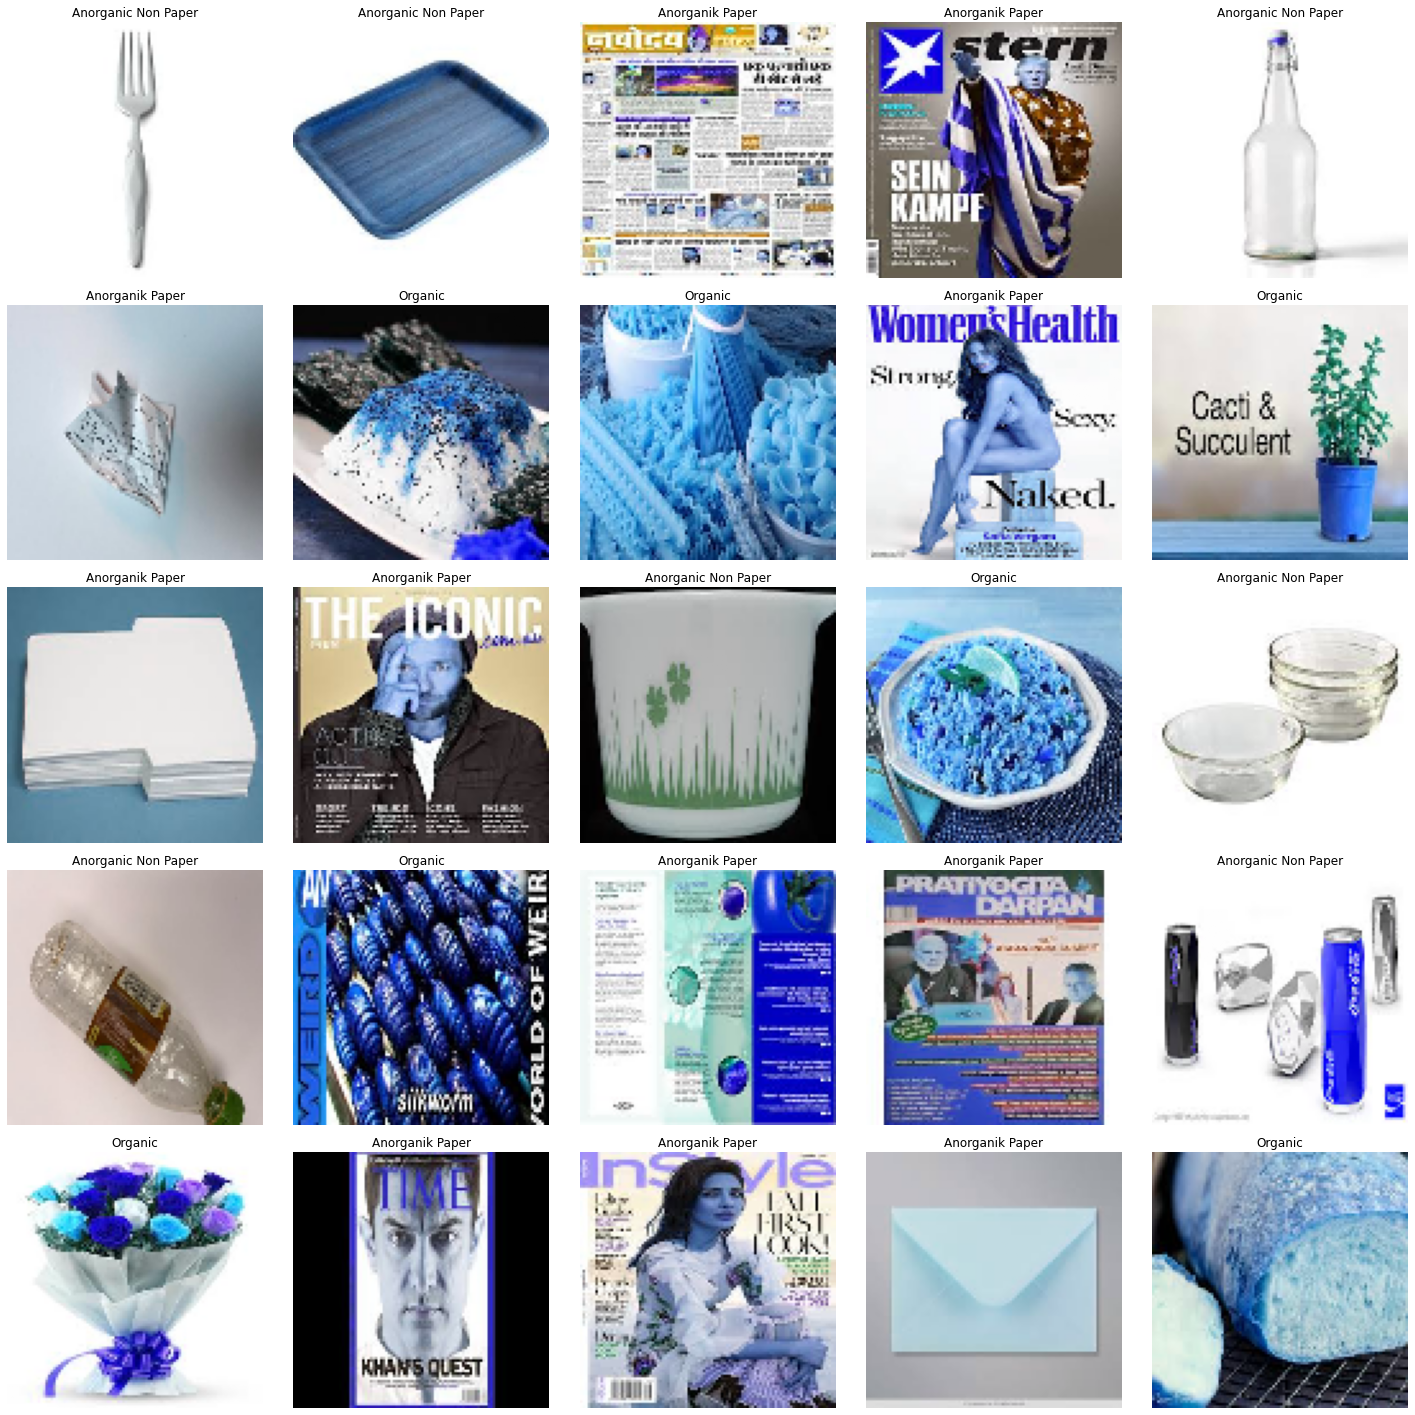

In [23]:
plt.figure(figsize=(20,20))
classes = target_labels
for i in range(1,26):
    index = np.random.randint(x_train.shape[0])
    plt.subplot(5, 5, i)
    plt.imshow(np.squeeze(x_train[index]))
    if classes[int(y_train[index])] == "Organic":
      plt.title("Organic")
    elif classes[int(y_train[index])] == "AnorganicNonPaper":
      plt.title("Anorganic Non Paper")
    else:
      plt.title("Anorganik Paper")
    plt.tight_layout()
    plt.axis('off')
plt.show() 

In [24]:
numberOfClass = len(target_labels)
print("Number Of Class: ",numberOfClass)

Number Of Class:  3


# Convolutional Neural Network - CNN Algorithm

In [25]:
model = Sequential()
model.add(Conv2D(32,(3,3),input_shape = (224,224,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D())

model.add(Conv2D(64,(3,3)))  
model.add(Activation("relu"))
model.add(MaxPooling2D())

model.add(Conv2D(128,(3,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(256))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(64))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(numberOfClass)) # output
model.add(Activation("softmax"))

model.compile(loss = "binary_crossentropy",
              optimizer = "adam",
              metrics = ["accuracy"])  

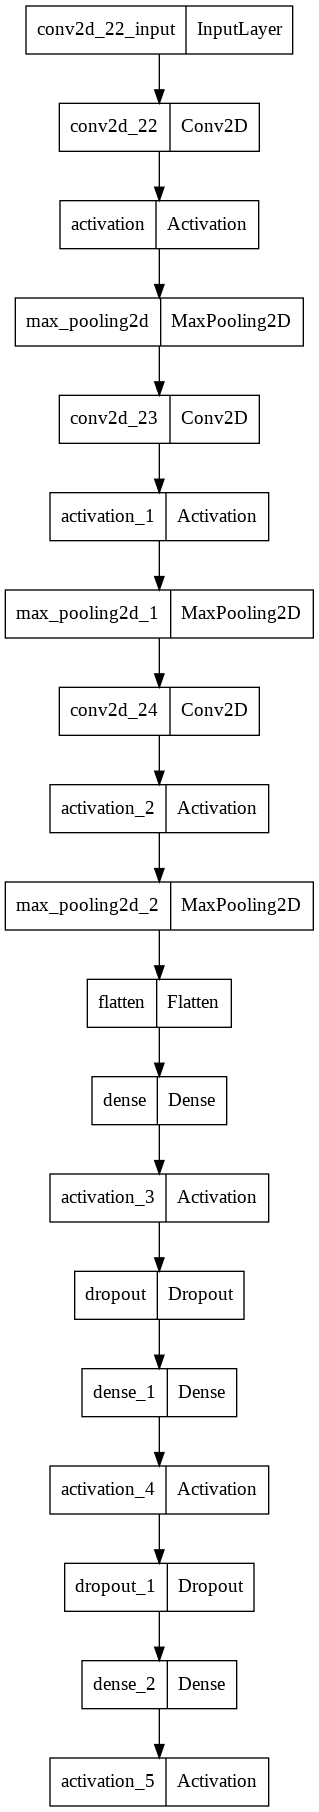

In [26]:
from keras.utils.vis_utils import plot_model
plot_model(model)

In [27]:
train_datagen = ImageDataGenerator(rescale = 1.0 / 255.0,
                                   validation_split = 0.2)

test_datagen = ImageDataGenerator(rescale = 1.0 / 255.0)

In [28]:
batch_size = 256
train_generator = train_datagen.flow_from_directory(
        train_dir, 
        target_size= (224,224),
        batch_size = batch_size,
        color_mode= "rgb",
        class_mode= "categorical",
        subset = 'training',
        seed= 42)

valid_generator = train_datagen.flow_from_directory(
        train_dir, 
        target_size= (224,224),
        batch_size = batch_size,
        color_mode= "rgb",
        class_mode= "categorical",
        subset = 'validation',
        seed= 42)

test_generator = test_datagen.flow_from_directory(
        test_dir, 
        target_size= (224,224),
        batch_size = 2500,
        color_mode= "rgb",
        class_mode= "categorical",
        seed= 42)

Found 17970 images belonging to 3 classes.
Found 4491 images belonging to 3 classes.
Found 2493 images belonging to 3 classes.


In [29]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
monitor = EarlyStopping(monitor='val_accuracy', patience=5, 
                        verbose=1, mode='max',restore_best_weights=True)

In [30]:
hist = model.fit_generator(
        generator = train_generator,
        epochs=30,
        validation_data = valid_generator,
        callbacks=monitor) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/30
71/71 [==============================] - 56s 693ms/step - loss: 0.5448 - accuracy: 0.6353 - val_loss: 0.4444 - val_accuracy: 0.6745
Epoch 2/30
71/71 [==============================] - 48s 675ms/step - loss: 0.4323 - accuracy: 0.7203 - val_loss: 0.4073 - val_accuracy: 0.7194
Epoch 3/30
71/71 [==============================] - 47s 658ms/step - loss: 0.4000 - accuracy: 0.7446 - val_loss: 0.3924 - val_accuracy: 0.7199
Epoch 4/30
71/71 [==============================] - 48s 673ms/step - loss: 0.3748 - accuracy: 0.7639 - val_loss: 0.3785 - val_accuracy: 0.7417
Epoch 5/30
71/71 [==============================] - 47s 656ms/step - loss: 0.3410 - accuracy: 0.7899 - val_loss: 0.3641 - val_accuracy: 0.7466
Epoch 6/30
71/71 [==============================] - 49s 681ms/step - loss: 0.3164 - accuracy: 0.8067 - val_loss: 0.3787 - val_accuracy: 0.7406
Epoch 7/30
71/71 [==============================] - 47s 663ms/step - loss: 0.2951 - accuracy: 0.8205 - val_loss: 0.3685 - val_accuracy: 0.7620

### Save History dan Model

In [31]:
# # mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [32]:
model.save('/content/drive/MyDrive/AI_ALP2022/cnn_model')


INFO:tensorflow:Assets written to: /content/drive/MyDrive/AI_ALP2022/cnn_model/assets


In [33]:
hist_df = pd.DataFrame(hist.history)

In [34]:
# or save to csv: 
hist_csv_file = '/content/drive/MyDrive/AI_ALP2022/history_fit.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

### Load History dan Model

In [35]:
# # mount drive
# from google.colab import drive
# drive.mount('/content/drive')

In [36]:

# url = "/content/drive/MyDrive/AI_ALP2022/history_fit.csv"
# historyCsv = pd.read_csv(url)
# historyCsv.head()

In [37]:
# model = tf.keras.models.load_model('/content/drive/MyDrive/AI_ALP2022/cnn_model')

### Plot data history

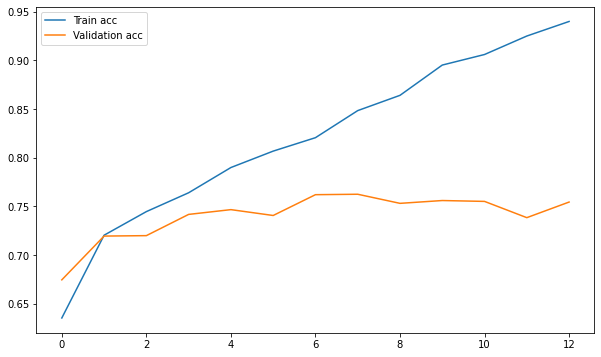

In [38]:
plt.figure(figsize=[10,6])
plt.plot(hist.history["accuracy"], label = "Train acc")
plt.plot(hist.history["val_accuracy"], label = "Validation acc")
plt.legend()
plt.show()

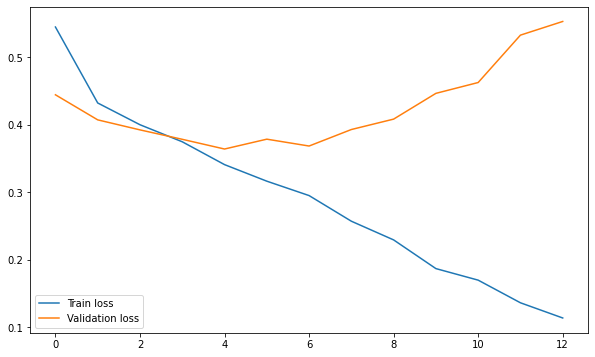

In [39]:
plt.figure(figsize=(10,6))
plt.plot(hist.history['loss'], label = "Train loss")
plt.plot(hist.history['val_loss'], label = "Validation loss")
plt.legend()
plt.show()

# Melakukan prediksi dengan test_x

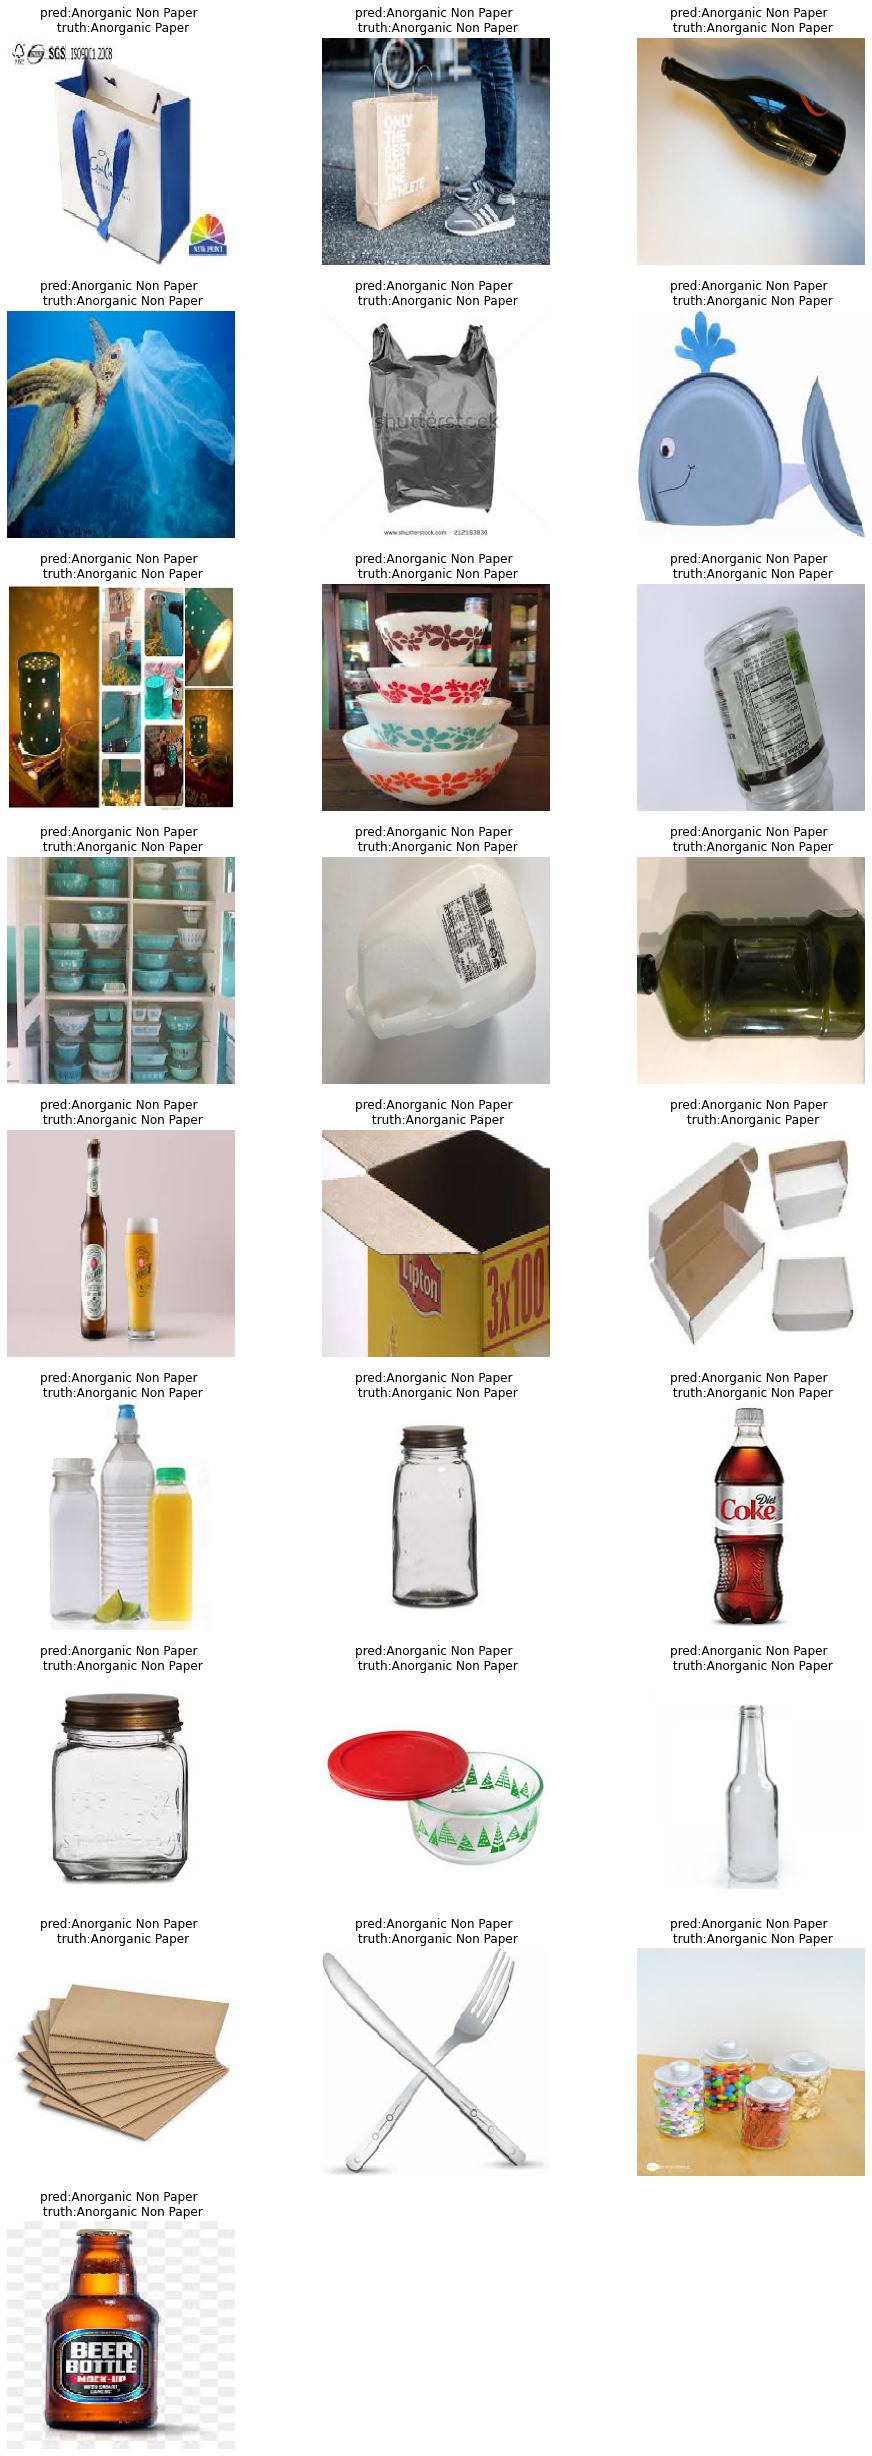

In [40]:
test_x, test_y = test_generator.__getitem__(0) #0 merupakan badge 0 dan perbadge isinya ada 2500 gambar

labels = (test_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
i=0
k=0
preds = model.predict(test_x)
plt.figure(figsize=(16, 200))
for j in range(100):
    
    if(np.argmax(preds[i]) == 0):
        accScore = round(np.max(preds[i])/np.sum(preds[i])*100, 2)
        plt.subplot(40, 3, k+1)
        if labels[np.argmax(preds[i])] == "Organic":
          prediction_caption = "Organic"
        elif labels[np.argmax(preds[i])] == "AnorganicNonPaper":
          prediction_caption = "Anorganic Non Paper"
        else:
          prediction_caption = "Anorganic Paper"
        if labels[np.argmax(test_y[i])] == "Organic":
          test_y_caption = "Organic"
        elif labels[np.argmax(test_y[i])] == "AnorganicNonPaper":
          test_y_caption = "Anorganic Non Paper"
        else:
          test_y_caption = "Anorganic Paper"
          
        plt.title('pred:%s \n truth:%s' % (prediction_caption, test_y_caption))
        plt.imshow(test_x[i])
        plt.axis('off')
        k=k+1
        i=i+1
    else:
        j = j-1
        i=i+1

# Prediksi gambar inputan lebih dari 1 gambar dalam 1 folder

In [41]:
# predict_datagen = ImageDataGenerator(rescale= 1./255)

In [42]:
# predict_generator = predict_datagen.flow_from_directory(
#         PATH_FILE, 
#         target_size= (224,224),
#         batch_size = batch_size,
#         color_mode= "rgb",
#         class_mode= "categorical")

In [43]:
# pred_x, pred_y = predict_generator.__getitem__(0)

# labels = (testall_generator.class_indices)
# labels = dict((v,k) for k,v in labels.items())

# predimg2 = model.predict(pred_x)

# plt.figure(figsize=(16, 16))
# for i in range(2):
#     plt.subplot(4, 4, i+1)
#     if labels[np.argmax(predimg2[i])] == "O":
#       plt.title("Organic")
#     elif labels[np.argmax(predimg2[i])] == "plastic":
#       plt.title("Anorganic Non Paper")
#     else:
#       plt.title("Anorganic Paper")
#     plt.imshow(pred_x[i])

# Prediksi gambar inputan untuk 1 gambar

In [44]:
from PIL import Image
INPUT_IMAGE_URL = "https://s1.bukalapak.com/img/12736452212/large/20200429_212850_1.jpg"

TEMP_FILE = '/content/testingImg.png'

!wget -q -O $TEMP_FILE $INPUT_IMAGE_URL
im = Image.open(TEMP_FILE)
im.thumbnail((512, 512), Image.ANTIALIAS)
im.save(TEMP_FILE, 'PNG')

In [45]:
img = cv2.imread(TEMP_FILE) 
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
imgtemp = img
img = cv2.resize(img,(224,224))

img = np.expand_dims(img, axis=0)
img = np.asarray(img,np.float32)/255

predimg = model.predict(img)
accScore = round(np.max(predimg)/np.sum(predimg)*100, 2)

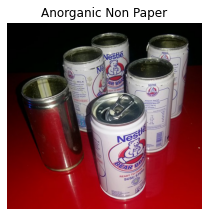

In [46]:
labels = (test_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())

plt.figure(figsize=(16, 16))
plt.subplot(4, 4, 1)
if labels[np.argmax(predimg)] == "Organic":
  plt.title("Organic")
elif labels[np.argmax(predimg)] == "AnorganicNonPaper":
  plt.title("Anorganic Non Paper")
else:
   plt.title("Anorganic Paper")
plt.axis('off')
plt.imshow(imgtemp)

# Check Result

In [47]:
y_pred = [np.argmax(x) for x in preds]
y_test = [np.argmax(x) for x in test_y]

In [48]:
cf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
print(cf_matrix)

[[ 610   51  126]
 [ 148  228   74]
 [  87   22 1147]]


[Text(50.99999999999999, 0.5, 'Truth'),
 Text(0.5, 15.0, 'Pred'),
 Text(0.5, 1.0, 'Heatmap')]

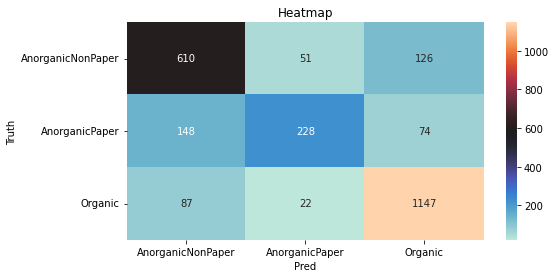

In [49]:
import seaborn as sns
cat = target_labels
plt.figure(figsize=(8,4))
ax = sns.heatmap(cf_matrix, annot=True, fmt='g', cmap="icefire", xticklabels=cat, yticklabels=cat)

ax.set(title="Heatmap",
      xlabel="Pred",
      ylabel="Truth",)

In [50]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

print('precision ', precision_score(y_test,y_pred, average="macro"))
print('recall  :', recall_score(y_test,y_pred, average="macro"))
print("Accuracy Score: ", accuracy_score(y_test, y_pred))
print('f1 Score : ', f1_score(y_test, y_pred, average="macro"))

precision  0.776963491566804
recall  : 0.731659508592836
Accuracy Score:  0.7962294424388288
f1 Score :  0.7453434168924638


In [51]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.78      0.75       787
           1       0.76      0.51      0.61       450
           2       0.85      0.91      0.88      1256

    accuracy                           0.80      2493
   macro avg       0.78      0.73      0.75      2493
weighted avg       0.79      0.80      0.79      2493



In [52]:
# model.save('/content/model_1')